In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def get_sval_scores(svals, n):
    """For computational efficiency, just compute svd once"""
    svals = np.asarray(svals).reshape(-1)
    regions = sum(svals > 0)

    schatten1 = sum(svals)
    evals = svals**2
    vec = np.asarray([
        i / n + np.sqrt(np.sum(evals[i:]) / n) for i in range(len(evals)+1)
    ])
    hstar = min(vec)

    return regions, hstar, schatten1

In [18]:
dataframes = []

datasets = ['train', 'test', 'ood_22', 'ood_45']
metrics = ['01_error', 'loss']
sval_metrics = []
for vals in ['0/1', 'true_label', 'est_label', 'est_proba']:
    for mat in ['full', 'pen']:
        sval_metrics.append(mat + '-' + vals)

columns = [
    'Architecture', 'run', 'n_parameters', 
]
for dataset in datasets:
    for metric in metrics:
        columns.append(metric + '-' + dataset)
    for metric in sval_metrics:
        for score in ['regions', 'h*', 'Schatten1']:
            columns.append(score + '-' + metric + '-' + dataset)


n = 1000

for run in range(10):
    results = np.load(f'rotation_results/results_{run}.npz', allow_pickle=True)
    for arch in ['w', 'd']:
        d = results[f'result_{arch}'].flatten()[0]
        sub_mat = []
        for dataset in datasets:
            for metric in metrics:
                sub_mat.append(np.asarray(d[dataset][metric]))
                
            for metric in sval_metrics:
                svals_list = d[dataset][metric]
                n_regions, hstars, schatten1s = list(zip(*
                    [get_sval_scores(svals, n) for svals in svals_list]
                ))
                sub_mat.append(n_regions)
                sub_mat.append(hstars)
                sub_mat.append(schatten1s)
        sub_mat = [
            ['width' if arch == 'w' else 'depth'] * len(sub_mat[0]),
            [run] * len(sub_mat[0]),
            d['n_parameters'],
        ] + sub_mat
        dataframes.append(pd.DataFrame({c: m for c, m in zip(columns, sub_mat)}))

In [19]:
df = pd.concat(dataframes, ignore_index=True)

In [20]:
df.to_csv('./rotation_results/results_table.csv', index=False)

In [21]:
df = pd.read_csv('./rotation_results/results_table.csv')

In [22]:
df

,Architecture,run,n_parameters,01_error-train,loss-train,regions-full-0/1-train,h*-full-0/1-train,Schatten1-full-0/1-train,regions-pen-0/1-train,h*-pen-0/1-train,...,Schatten1-full-est_label-ood_45,regions-pen-est_label-ood_45,h*-pen-est_label-ood_45,Schatten1-pen-est_label-ood_45,regions-full-est_proba-ood_45,h*-full-est_proba-ood_45,Schatten1-full-est_proba-ood_45,regions-pen-est_proba-ood_45,h*-pen-est_proba-ood_45,Schatten1-pen-est_proba-ood_45
0,width,0,11,0.500,0.693147,1,0.001,31.622777,1,0.001,...,31.622777,1,0.001,31.622777,0,0.000000,0.000000,0,0.000000,0.000000
1,width,0,27,0.413,0.664774,6,0.006,54.309529,117,0.117,...,52.671379,123,0.123,159.531800,5,0.005000,13.119663,123,0.079401,33.634918
2,width,0,49,0.330,0.605671,17,0.017,108.962572,743,0.743,...,110.096967,756,0.756,770.652476,17,0.017000,40.471792,756,0.335684,239.959135
3,width,0,77,0.264,0.512581,44,0.044,165.531962,872,0.872,...,160.083041,860,0.860,876.191496,41,0.041000,83.044555,860,0.454168,358.090771
4,width,0,111,0.262,0.500701,82,0.082,226.835404,1000,1.000,...,229.120106,1000,1.000,1000.000000,78,0.074193,112.070156,1000,0.552336,465.472038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,depth,9,5961,0.204,0.397965,736,0.736,825.373766,925,0.925,...,818.034009,938,0.938,944.937254,726,0.546579,454.561618,938,0.627147,520.859261
866,depth,9,6381,0.275,0.521434,548,0.548,686.903953,1000,1.000,...,679.333862,998,0.998,998.732051,532,0.297619,250.466182,998,0.474915,361.644827
867,depth,9,6801,0.206,0.439577,751,0.751,837.460549,998,0.998,...,872.887273,995,0.995,996.449490,800,0.584003,471.960346,995,0.622673,543.987309
868,depth,9,7221,0.230,0.448977,830,0.830,892.547567,988,0.988,...,892.449528,985,0.985,988.000000,833,0.527143,442.959187,985,0.607261,493.925277


In [29]:
plot_datasets = ['train', 'test', 'ood_22', 'ood_45']
plot_metrics = [
    '01_error',
    'loss',
    'regions-full-0/1',
    'h*-full-0/1',
    'Schatten1-full-0/1',
    'regions-pen-0/1',
    'h*-pen-0/1',
    'Schatten1-pen-0/1',
]
row_y = [
    [f'{pm}-{pd}' for pd in plot_datasets]
    for pm in plot_metrics
]

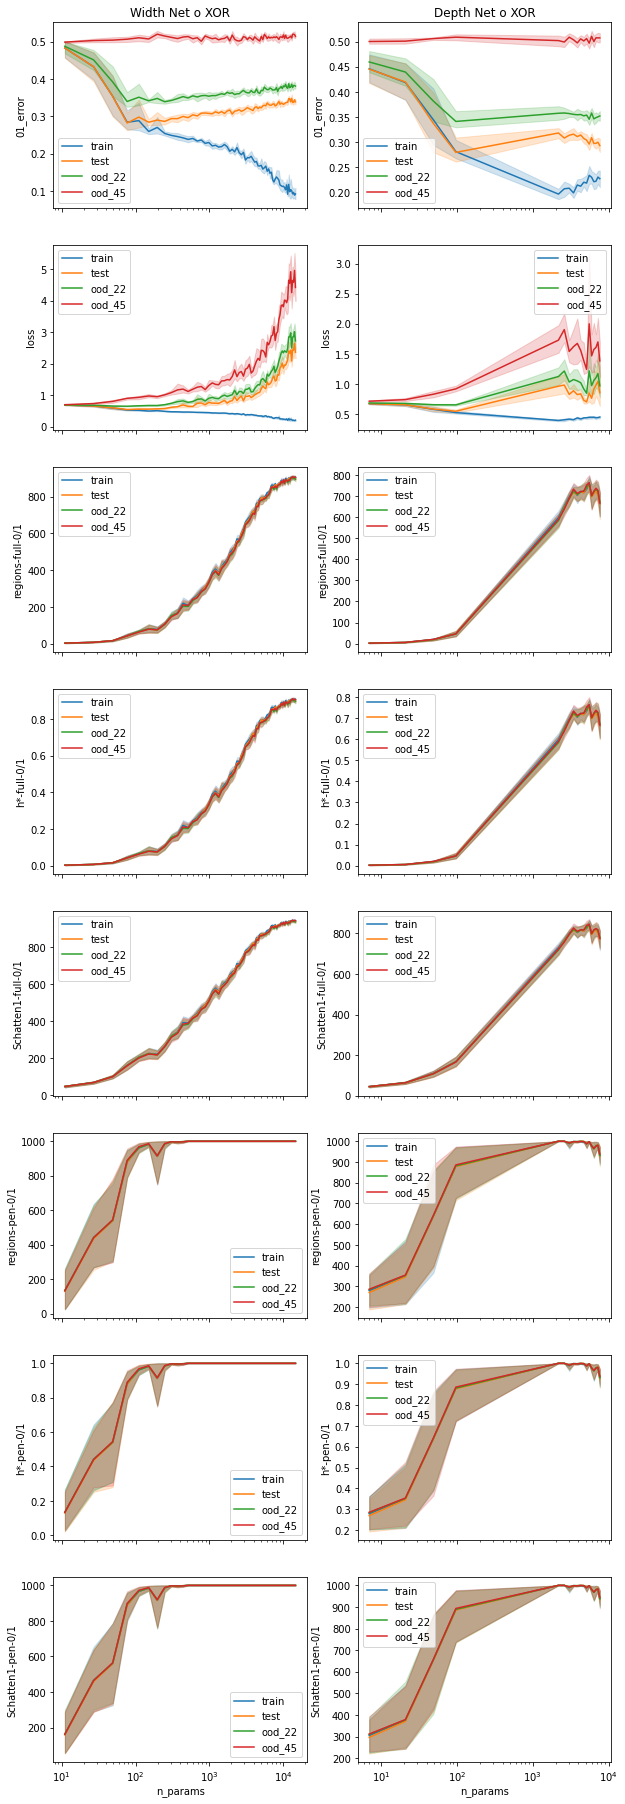

In [30]:
fig, axes = plt.subplots(len(row_y), 2, figsize=(10, 4*len(row_y)), sharex='col')#, sharex='col')#, sharey='row')
for col, arch in enumerate(['width', 'depth']):
    for row, metric in enumerate(plot_metrics):
        ax = axes[row, col]
        for ds in plot_datasets:
            sns.lineplot(
                data=df[df['Architecture'] == arch],
                x='n_parameters', y=f'{metric}-{ds}',
                ax=ax, label=ds)
        ax.set_ylabel(metric)
axes[0, 0].set_title('Width Net o XOR')
axes[0, 1].set_title('Depth Net o XOR')
for ax in (axes[-1, 0], axes[-1, 1]):
    ax.set_xlabel('n_params')
    ax.set_xscale('log')

In [41]:
plot_datasets = ['train', 'test', 'ood_22', 'ood_45']
plot_metrics = [
    '01_error',
    'loss',
    'regions-full-est_proba',
    'h*-full-est_proba',
    'Schatten1-full-est_proba',
    'regions-pen-est_proba',
    'h*-pen-est_proba',
    'Schatten1-pen-est_proba',
]
row_y = [
    [f'{pm}-{pd}' for pd in plot_datasets]
    for pm in plot_metrics
]

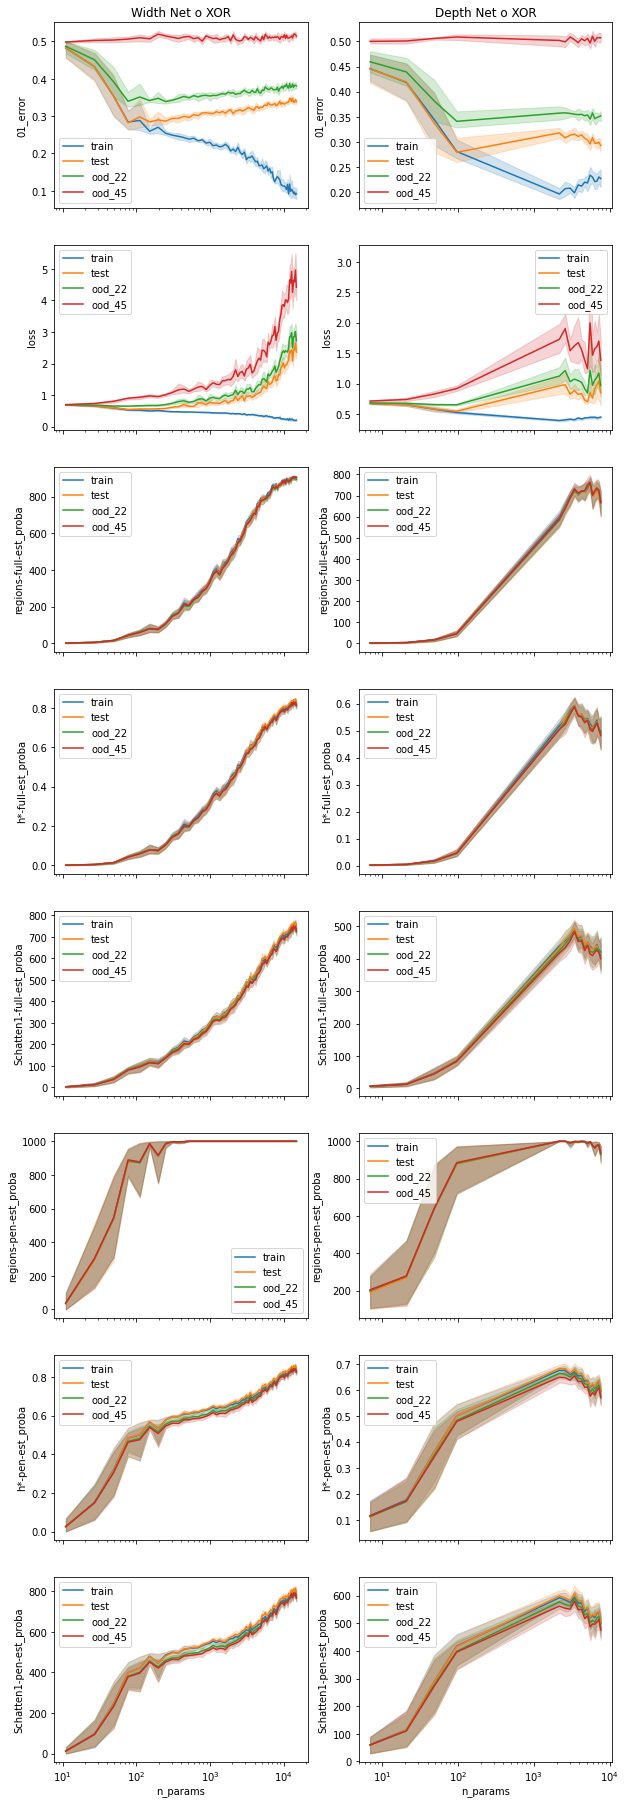

In [42]:
fig, axes = plt.subplots(len(row_y), 2, figsize=(10, 4*len(row_y)), sharex='col')#, sharex='col')#, sharey='row')
for col, arch in enumerate(['width', 'depth']):
    for row, metric in enumerate(plot_metrics):
        ax = axes[row, col]
        for ds in plot_datasets:
            sns.lineplot(
                data=df[df['Architecture'] == arch],
                x='n_parameters', y=f'{metric}-{ds}',
                ax=ax, label=ds)
        ax.set_ylabel(metric)
axes[0, 0].set_title('Width Net o XOR')
axes[0, 1].set_title('Depth Net o XOR')
for ax in (axes[-1, 0], axes[-1, 1]):
    ax.set_xlabel('n_params')
    ax.set_xscale('log')